# LSI and LDA - Topic Modelling

In [16]:
# Librerías
import re
from gensim import corpora
from pathlib import Path
from gensim.models import LsiModel
from gensim.parsing.preprocessing import preprocess_string
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.style as style

In [2]:
# Funciones de Preprocesamiento de los datos

def clean_text(x):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern, '', x)
    return text

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0,9]{3}', '###', x)
        x = re.sub('[0,9]{2}', '##', x)
    return x

def clean(x):
    x = clean_text(x)
    x = clean_numbers(x)
    return x

In [3]:
# Funciones para cargar los artículos

def load_articles(data_dir):
    routers = Path(data_dir)
    for path in routers.glob('*.sgm'):
        with path.open() as sgm_file:
            contents = sgm_file.read()
            soup = BeautifulSoup(contents)
            for article in soup.find_all('body'):
                yield article.text

In [4]:
"""
Ahora vamos a crear funciones para poder cargar los archivos desde el directorio, para crear representaciones vectoriales de cada uno. Y construir el modelo LSI/LSA con los mismos.
"""

def load_documents(document_dir):
    print(f'Loading from {document_dir}')
    documents = list(load_articles(document_dir))
    print(f'Loaded {len(documents)} documents.')
    return documents

def prepare_documents(documents):
    print('Preparing Documents...')
    documents = [clean(document) for document in documents]
    documents = [preprocess_string(doc) for doc in documents]
    return documents

def create_lsa_model(documents, dictrionary, number_of_topics):
    print(f'Creating LSA model with {number_of_topics} topics.')
    document_terms = [dictrionary.doc2bow(doc) for doc in documents]
    return LsiModel(document_terms,
                    num_topics=number_of_topics,
                    id2word=dictrionary)

def run_lsa_process(documents, number_of_topics=10):
    documents = prepare_documents(documents)
    dictionary = corpora.Dictionary(documents)
    lsa_model = create_lsa_model(documents, dictionary,
                                 number_of_topics)
    return documents, dictionary, lsa_model

In [12]:
document_dir = 'data/reuters'
articles = list(load_articles(document_dir))
documents, dictionary, model = run_lsa_process(articles, number_of_topics=8)

Preparing Documents...
Creating LSA model with 8 topics.


In [13]:
model.print_topics()

[(0,
  '0.650*"said" + 0.288*"dlr" + 0.275*"mln" + 0.215*"pct" + 0.174*"year" + 0.167*"bank" + 0.144*"reuter" + 0.144*"billion" + 0.124*"compani" + 0.115*"market"'),
 (1,
  '-0.675*"mln" + -0.389*"dlr" + 0.345*"said" + -0.193*"ct" + -0.170*"net" + -0.162*"loss" + -0.161*"shr" + 0.119*"bank" + 0.104*"market" + -0.094*"profit"'),
 (2,
  '-0.598*"pct" + -0.363*"billion" + -0.357*"bank" + 0.325*"said" + 0.193*"compani" + 0.170*"share" + -0.149*"rate" + -0.134*"year" + 0.101*"stock" + -0.100*"januari"'),
 (3,
  '0.695*"bank" + -0.504*"pct" + -0.136*"price" + 0.118*"loan" + 0.115*"debt" + -0.107*"year" + 0.105*"dlr" + -0.097*"product" + -0.077*"compani" + 0.074*"billion"'),
 (4,
  '0.810*"nil" + -0.322*"dlr" + 0.212*"mln" + 0.148*"prev" + -0.147*"billion" + -0.117*"share" + -0.096*"compani" + 0.093*"tonn" + 0.088*"export" + 0.084*"market"'),
 (5,
  '0.548*"dlr" + 0.495*"nil" + -0.386*"mln" + 0.315*"billion" + 0.134*"share" + -0.113*"ct" + -0.112*"market" + 0.111*"compani" + -0.102*"shr" + 0.

In [14]:
from gensim.models.coherencemodel import CoherenceModel

def calculate_coherence_score(documents, dictionary, model):
    coherence_model = CoherenceModel(model=model,
                                     texts=documents,
                                     dictionary=dictionary,
                                     coherence='c_v')
    return coherence_model.get_coherence()

def get_coherence_values(start, stop):
    for num_topics in range(start, stop):
        print(f'\nCalculating coherence for {num_topics} topics.')
        documents, dictionary, model = run_lsa_process(articles,
                                                       number_of_topics=num_topics)
        coherence = calculate_coherence_score(documents,
                                              dictionary,
                                              model)
        yield coherence

In [15]:
min_topics, max_topics = 20, 40
coherence_scores = list(get_coherence_values(min_topics, max_topics))


Calculating coherence for 20 topics.
Preparing Documents...
Creating LSA model with 20 topics.

Calculating coherence for 21 topics.
Preparing Documents...
Creating LSA model with 21 topics.

Calculating coherence for 22 topics.
Preparing Documents...
Creating LSA model with 22 topics.

Calculating coherence for 23 topics.
Preparing Documents...
Creating LSA model with 23 topics.

Calculating coherence for 24 topics.
Preparing Documents...
Creating LSA model with 24 topics.

Calculating coherence for 25 topics.
Preparing Documents...
Creating LSA model with 25 topics.

Calculating coherence for 26 topics.
Preparing Documents...
Creating LSA model with 26 topics.

Calculating coherence for 27 topics.
Preparing Documents...
Creating LSA model with 27 topics.

Calculating coherence for 28 topics.
Preparing Documents...
Creating LSA model with 28 topics.

Calculating coherence for 29 topics.
Preparing Documents...
Creating LSA model with 29 topics.


Text(0.5, 1.0, 'Coherence Scores by Number of Topics')

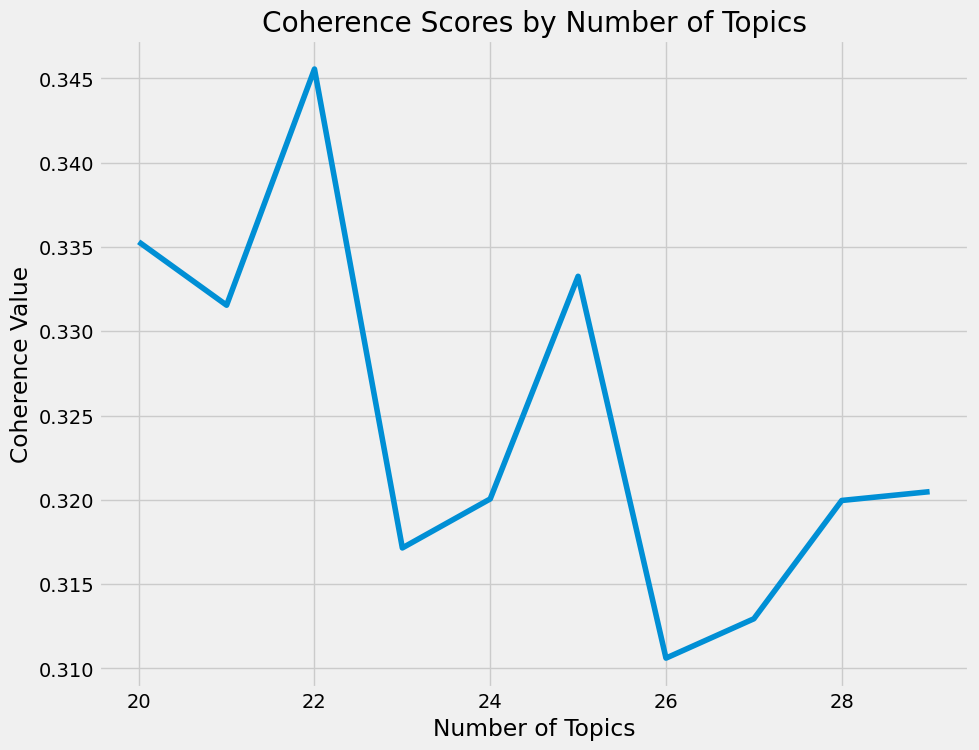

In [17]:
style.use('fivethirtyeight')

x = [int(i) for i in range(min_topics, max_topics)]

plt.figure(figsize=(10, 8))
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores by Number of Topics')